# 1. Data Preparation

### Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import splitfolders

In [2]:

input_folder="stage2_train"
output="Knee_Dataset/processed_data"

In [ ]:
splitfolders.ratio(input_folder,output, seed=42, ratio=(.8,.1,.1))

In [3]:
np.random.seed(12049)

In [4]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data} - {classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path = os.path.join(data_path, str(k), v[i])
            img = tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1 + i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

## Load data

In [5]:
# Class names
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [6]:
train_path = r"Knee_Dataset\processed_data\train"
valid_path = r"Knee_Dataset\processed_data\val"
test_path = r"Knee_Dataset\processed_data\test"

In [7]:
train_data = get_classes(train_path, class_names, 'Train')
valid_data = get_classes(valid_path, class_names, 'Valid')
tests_data = get_classes(test_path, class_names, 'Test')

---- Train ----
Grade 0 - Healthy: 1828 images, 40.21%
Grade 1 - Doubtful: 763 images, 16.78%
Grade 2 - Minimal: 1212 images, 26.66%
Grade 3 - Moderate: 605 images, 13.31%
Grade 4 - Severe: 138 images, 3.04%
---- Valid ----
Grade 0 - Healthy: 228 images, 40.28%
Grade 1 - Doubtful: 95 images, 16.78%
Grade 2 - Minimal: 151 images, 26.68%
Grade 3 - Moderate: 75 images, 13.25%
Grade 4 - Severe: 17 images, 3.0%
---- Test ----
Grade 0 - Healthy: 230 images, 40.07%
Grade 1 - Doubtful: 96 images, 16.72%
Grade 2 - Minimal: 153 images, 26.66%
Grade 3 - Moderate: 77 images, 13.41%
Grade 4 - Severe: 18 images, 3.14%


## Visualize data

### Train data

Train data - Healthy


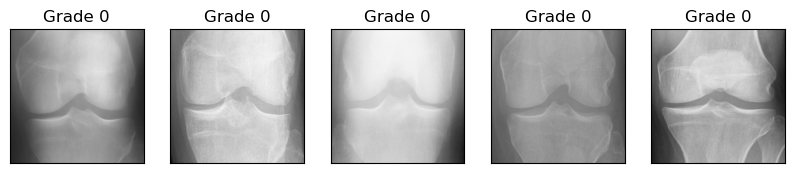

Train data - Doubtful


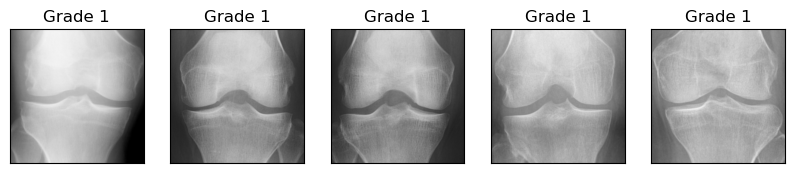

Train data - Minimal


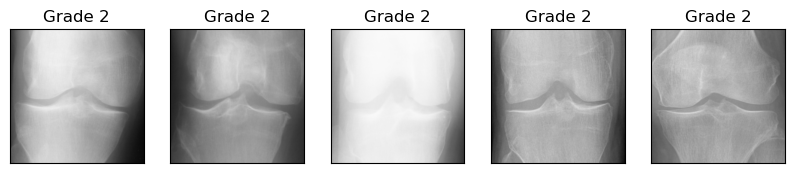

Train data - Moderate


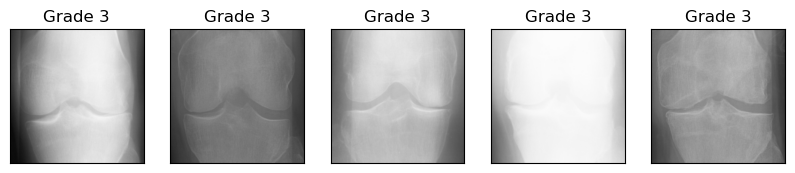

Train data - Severe


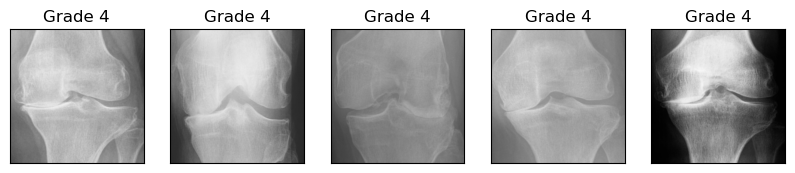

In [8]:
plot_classes(train_data, train_path, class_names, 'Train data')

### Valid data

Valid data - Healthy


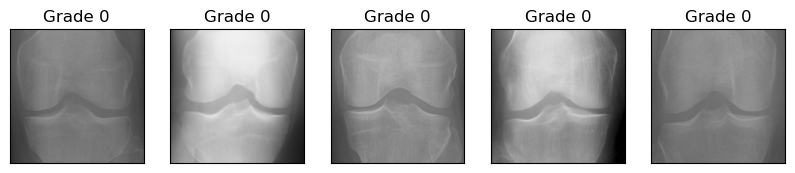

Valid data - Doubtful


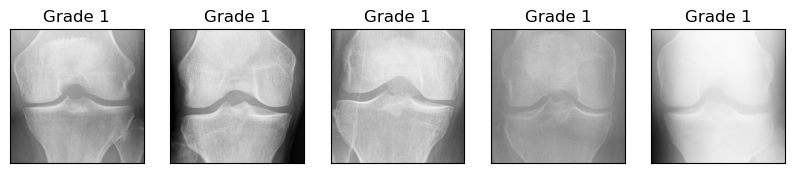

Valid data - Minimal


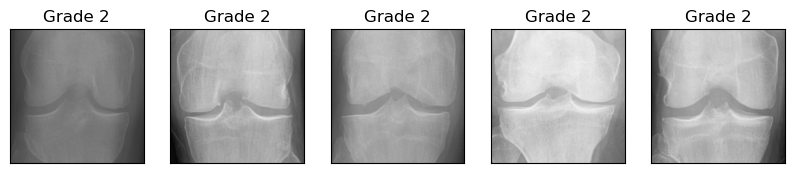

Valid data - Moderate


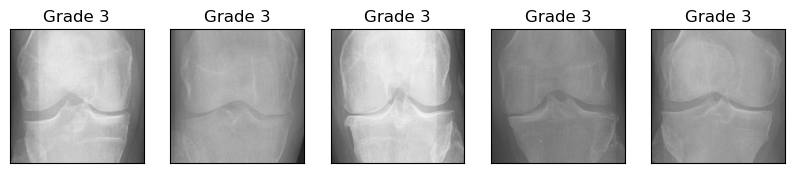

Valid data - Severe


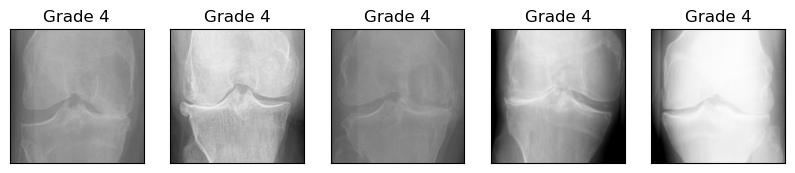

In [9]:
plot_classes(valid_data, valid_path, class_names, 'Valid data')

### Test data

Test data - Healthy


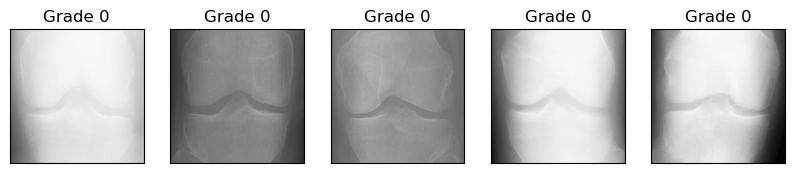

Test data - Doubtful


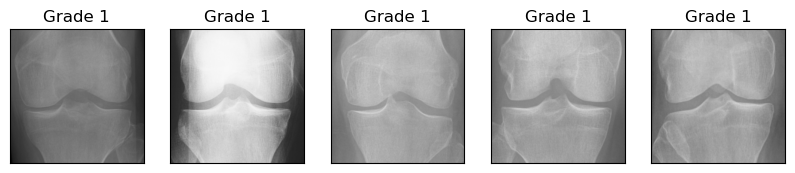

Test data - Minimal


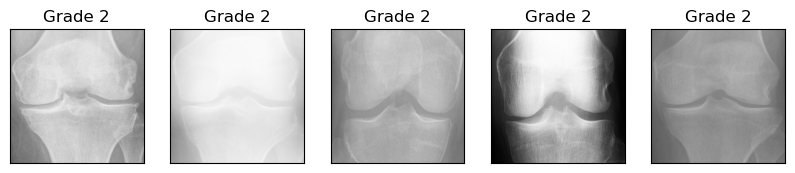

Test data - Moderate


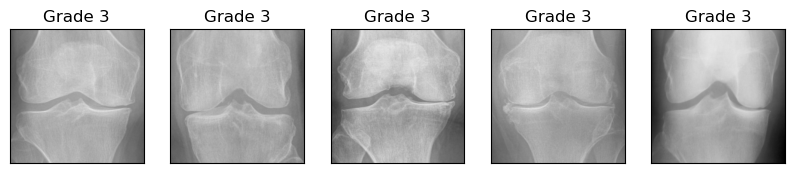

Test data - Severe


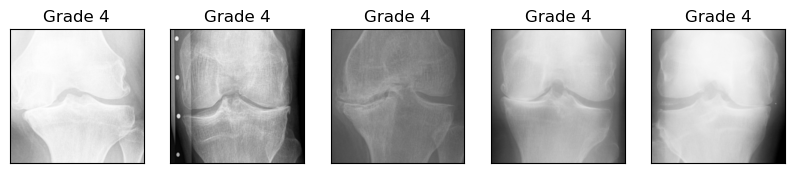

In [10]:
plot_classes(tests_data, test_path, class_names, 'Test data')

## Image Data Generator Examples

#### brightness_range

Found 4546 images belonging to 5 classes.


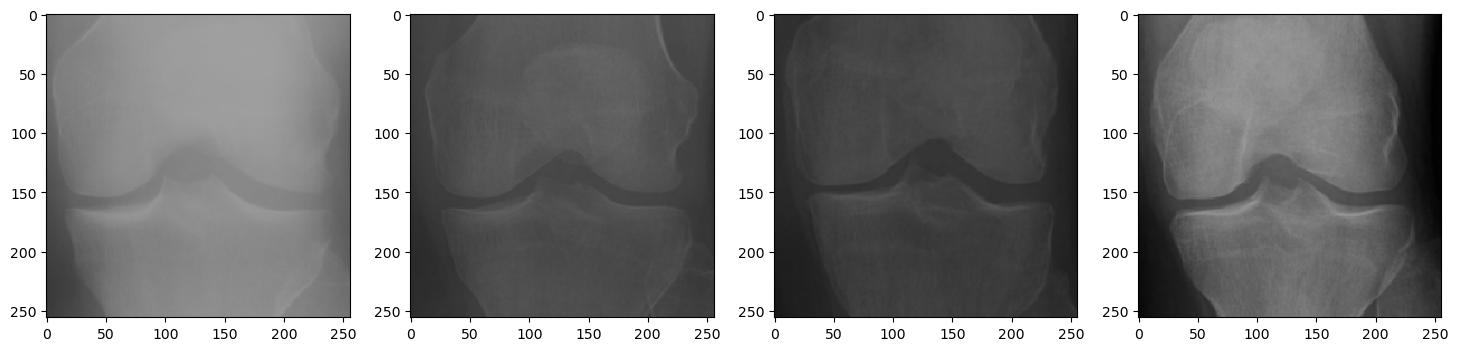

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[0.3, 0.8]
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype("uint8"))
plt.show()

#### width_shift_range

Found 4546 images belonging to 5 classes.


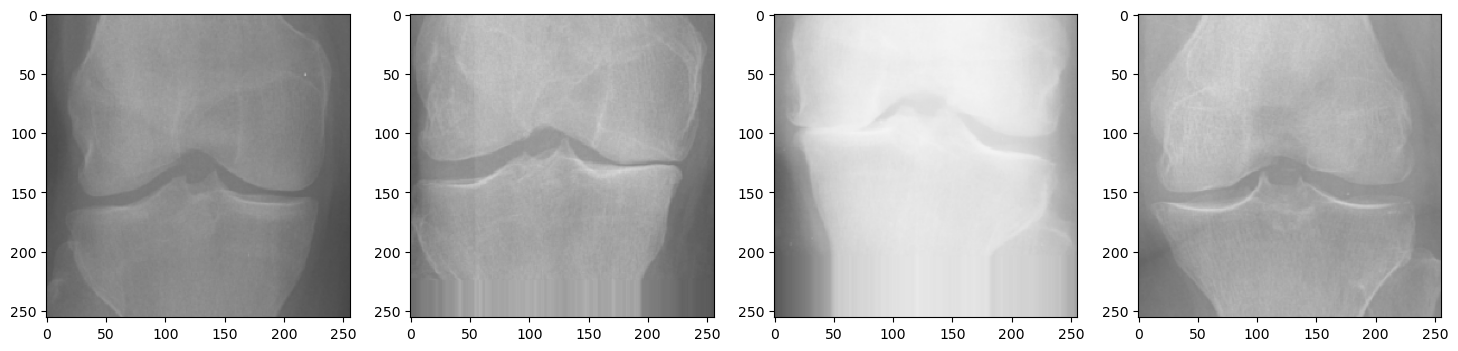

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=[-50,0,50,30,-30]
)
imagegen = datagen.flow_from_directory(train_path, batch_size=5)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

#### zoom_range

Found 4546 images belonging to 5 classes.


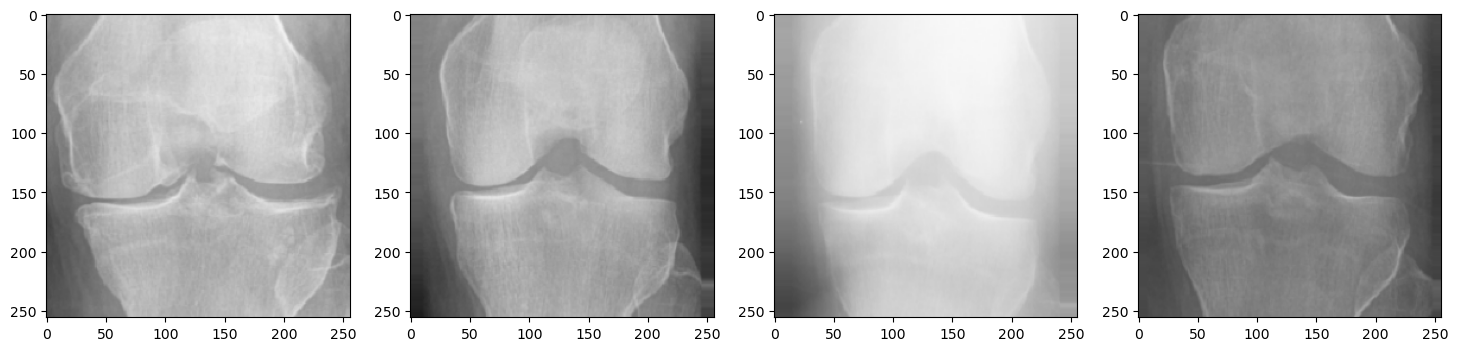

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

#### horizontal_flip

Found 4546 images belonging to 5 classes.


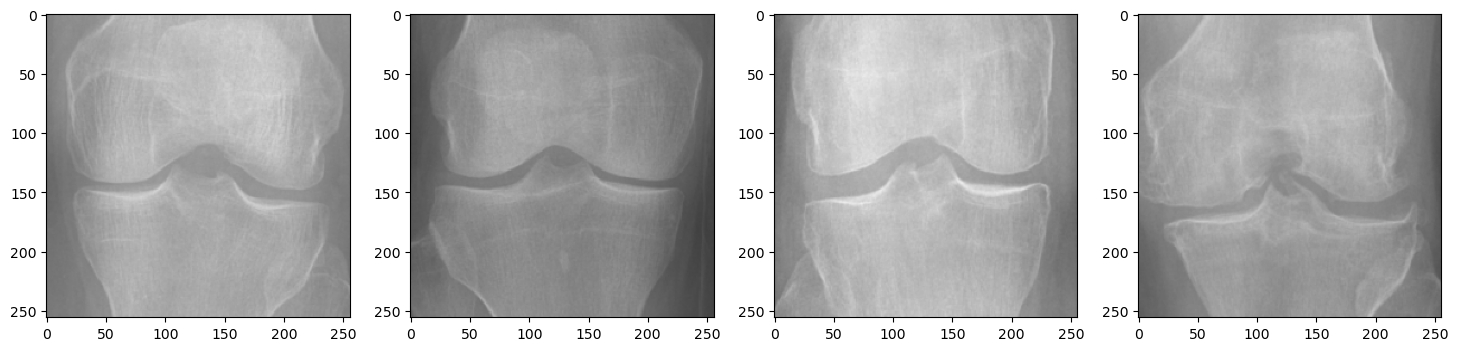

In [14]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

## Image Data Generator and Preprocess

In [15]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [16]:
target_size = (224, 224)

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False/,
)

Found 4546 images belonging to 5 classes.
Found 566 images belonging to 5 classes.


In [17]:
y_train = train_generator.labels
y_val = valid_generator.labels

## Class weight

In [18]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train --->  {0: 1828, 1: 763, 2: 1212, 3: 605, 4: 138}
{0: 0.4973741794310722, 1: 1.1916120576671034, 2: 0.7501650165016501, 3: 1.502809917355372, 4: 6.58840579710145}
